In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import cv2
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt
import os

C:\Users\sgold\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
learning_rate = 0.001
batch_size = 10
epochs = 10


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [3]:
train_path = 'C:/Users/sgold/laba5/train'
test_path = 'C:/Users/sgold/laba5/test'
val_path = 'C:/Users/sgold/laba5/val'
path_to_dataset=r"C:/Users/sgold/laba5/dataset/"

df = pd.read_csv(os.path.join(path_to_dataset, "C:/Users/sgold/laba5/dataset_csv.csv"), header=None, delimiter=";", names=['path_to_image', 'label'])
if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    image_path = df.path_to_image[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.label[i]}.{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    image_path = df.path_to_image[i]
    image = cv2.imread(image_path)
    if i - 880 > 109: 
        i = i - 1870
    else:
        i = i -880
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)


for i in range(880):
    load_train(df, train_path, i)

for i in range(880, 990):
    load_test(df, test_path, i)

for i in range(990, 1100):
    load_train(df, val_path, i)

for i in range(1100, 1980):
    load_train(df, train_path, i)

for i in range(1980, 2090):
    load_test(df, test_path, i)

for i in range(2090, 2200):
    load_train(df, val_path, i)
    

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))
train_list, val_list = train_test_split(train_list, test_size=0.1)
    

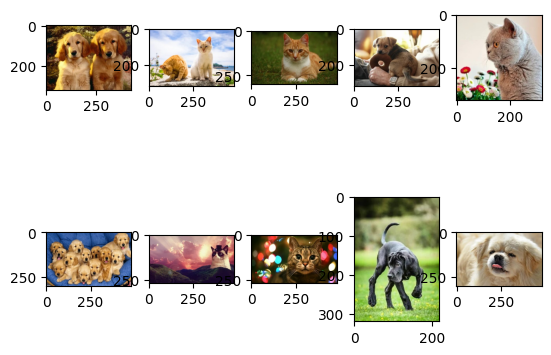

In [5]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

In [13]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = Cnn().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [15]:
from PIL import Image

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
            
        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

Learning rate: 0.001, Batch size: 10


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.7525155544281006, train loss : 0.4854019284248352


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.7944444417953491, val_loss : 0.45927974581718445
Epoch : 2, train accuracy : 0.7786161303520203, train loss : 0.4581483006477356
Epoch : 2, val_accuracy : 0.8240741491317749, val_loss : 0.4489766061306
Epoch : 3, train accuracy : 0.7801886200904846, train loss : 0.4487687945365906
Epoch : 3, val_accuracy : 0.7888889908790588, val_loss : 0.4531136155128479
Epoch : 4, train accuracy : 0.7748426795005798, train loss : 0.45114168524742126
Epoch : 4, val_accuracy : 0.7685185670852661, val_loss : 0.46722105145454407
Epoch : 5, train accuracy : 0.7745282053947449, train loss : 0.4473738968372345
Epoch : 5, val_accuracy : 0.7481481432914734, val_loss : 0.5585717558860779
Epoch : 6, train accuracy : 0.7864778637886047, train loss : 0.44126683473587036
Epoch : 6, val_accuracy : 0.7703703045845032, val_loss : 0.5206030607223511
Epoch : 7, train accuracy : 0.7845913171768188, train loss : 0.44413918256759644
Epoch : 7, val_accuracy : 0.7851851582527161, val_loss : 0.480

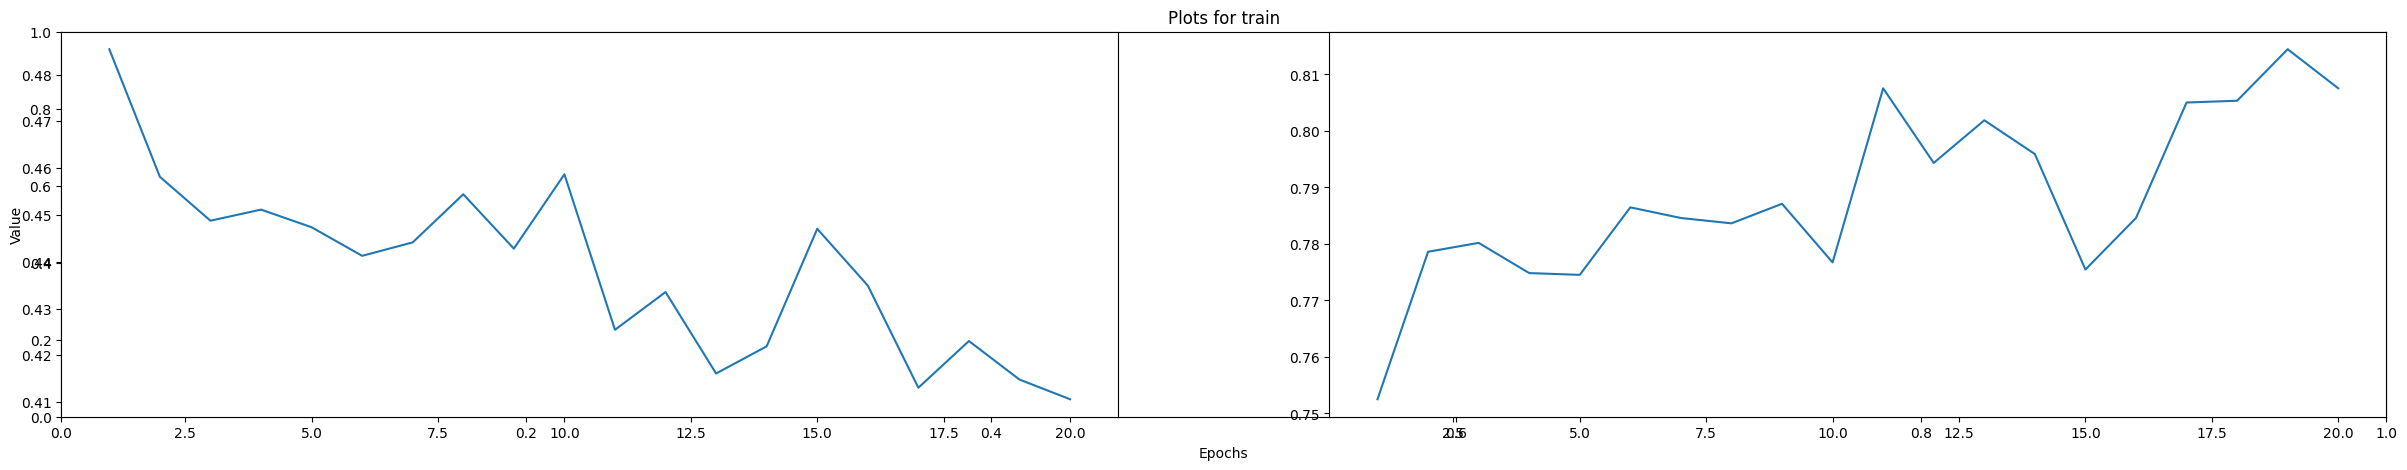

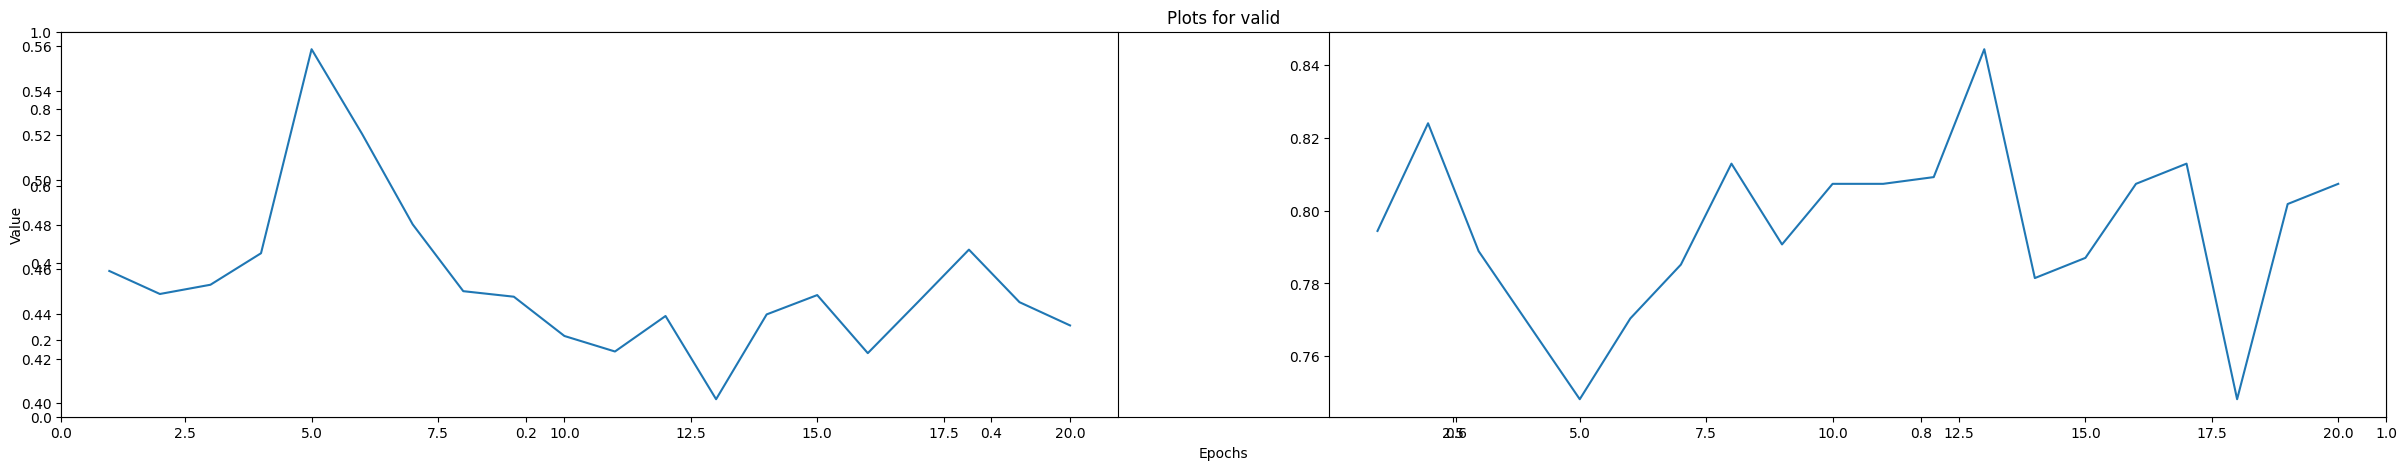

In [18]:
print('Learning rate: 0.001, Batch size: 10')

optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

epochs = 20

def train_loop (train_loader, val_loader, epochs):
    val_loss_list = []
    val_accuracy_list = []

    loss_list = []
    accuracy_list = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = torch.tensor(data).to(device)
            label = torch.tensor(label).to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)

        loss_list.append(epoch_loss.item())
        accuracy_list.append(epoch_accuracy.item())

        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
        
        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0

            for data, label in val_loader:
                data = torch.tensor(data).to(device)
                label = torch.tensor(label).to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)

            
            val_loss_list.append(epoch_val_loss.item())
            val_accuracy_list.append(epoch_val_accuracy.item())
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
    

    num_epochs = [i+1 for i in range(epochs)]

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for train')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, loss_list, label = 'loss') 
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, accuracy_list, label = 'accuracy')

    fig = plt.figure(figsize=(30, 5))
    plt.title('Plots for valid')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    fig.add_subplot(1,2,1)
    plt.plot(num_epochs, val_loss_list, label = 'loss')
    fig.add_subplot(1,2,2)
    plt.plot(num_epochs, val_accuracy_list, label = 'accuracy')

train_loop(train_loader, val_loader, epochs)


Learning rate: 0.0005, Batch size: 10


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8226410746574402, train loss : 0.37667378783226013


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.7814814448356628, val_loss : 0.44303521513938904
Epoch : 2, train accuracy : 0.7996855974197388, train loss : 0.4031338095664978
Epoch : 2, val_accuracy : 0.8018518686294556, val_loss : 0.48976874351501465
Epoch : 3, train accuracy : 0.801572322845459, train loss : 0.40670260787010193
Epoch : 3, val_accuracy : 0.833333432674408, val_loss : 0.36456048488616943
Epoch : 4, train accuracy : 0.8364777565002441, train loss : 0.36646339297294617
Epoch : 4, val_accuracy : 0.8740741014480591, val_loss : 0.35413795709609985
Epoch : 5, train accuracy : 0.8176100254058838, train loss : 0.3842153549194336
Epoch : 5, val_accuracy : 0.7611111402511597, val_loss : 0.48549461364746094
Epoch : 6, train accuracy : 0.8172954320907593, train loss : 0.3910016119480133
Epoch : 6, val_accuracy : 0.7851852178573608, val_loss : 0.4738450050354004
Epoch : 7, train accuracy : 0.8283016681671143, train loss : 0.3693905174732208
Epoch : 7, val_accuracy : 0.8407407999038696, val_loss : 0.

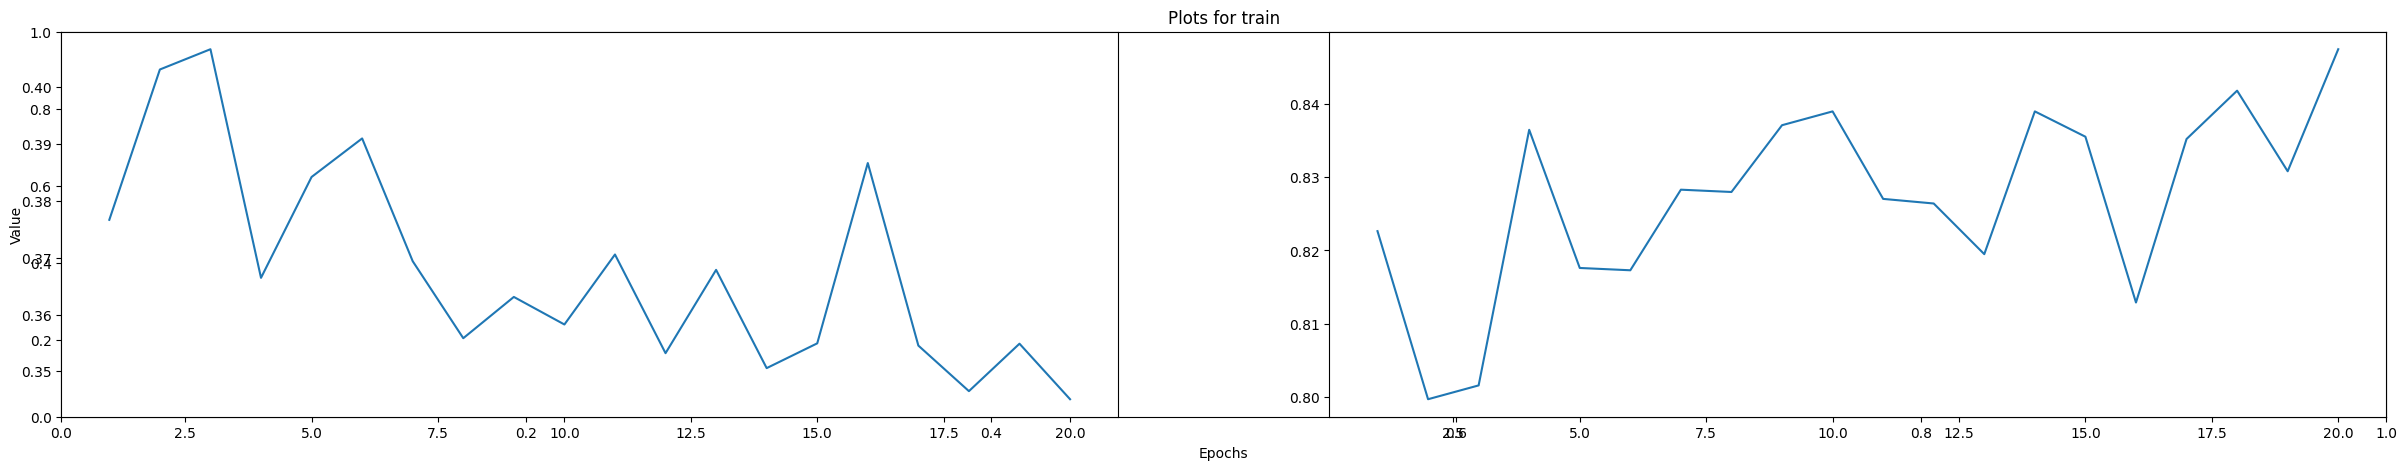

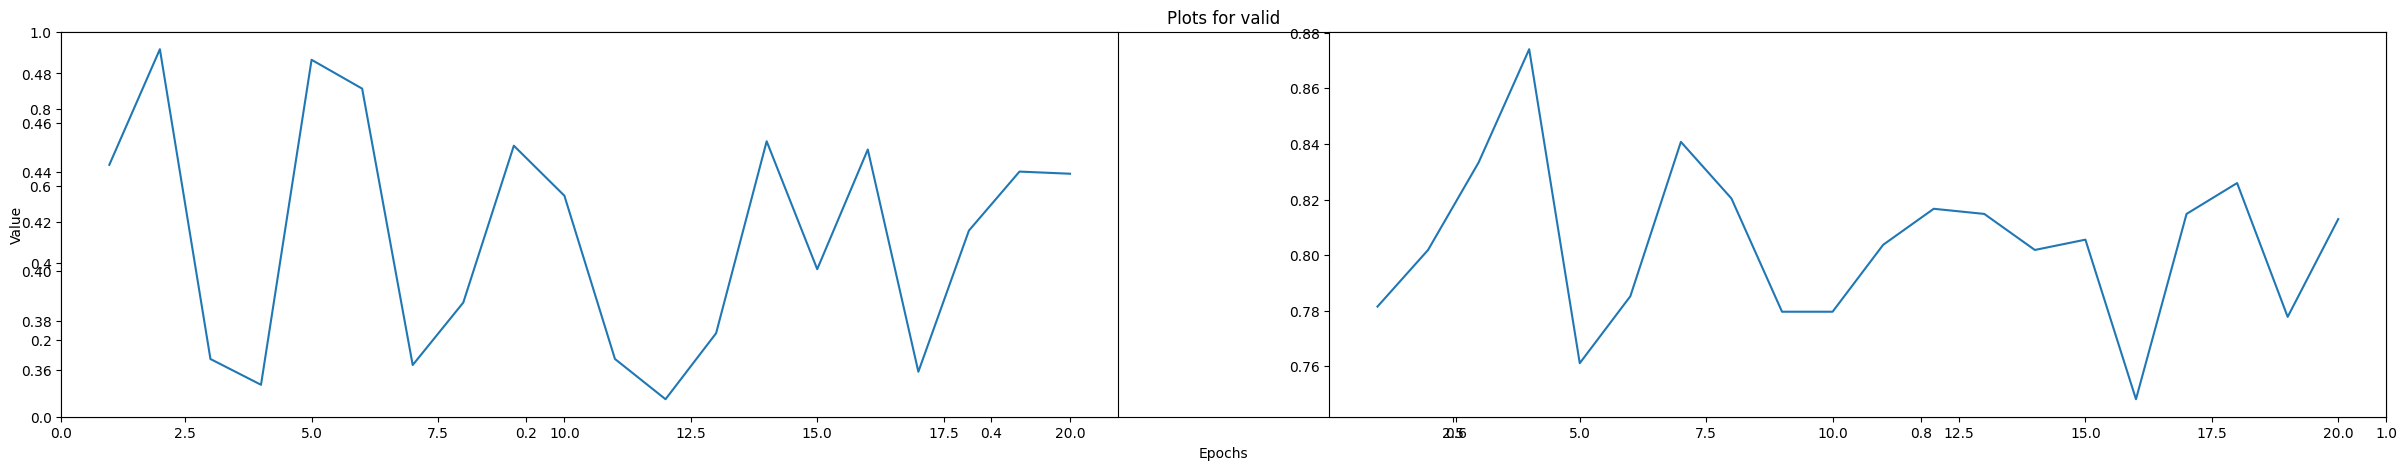

In [19]:
print('Learning rate: 0.0005, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 10


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8371068835258484, train loss : 0.34606820344924927


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8481481671333313, val_loss : 0.38733506202697754
Epoch : 2, train accuracy : 0.8176100850105286, train loss : 0.3781069219112396
Epoch : 2, val_accuracy : 0.8259260058403015, val_loss : 0.3926396071910858
Epoch : 3, train accuracy : 0.8301883339881897, train loss : 0.367281973361969
Epoch : 3, val_accuracy : 0.8240740299224854, val_loss : 0.35417377948760986
Epoch : 4, train accuracy : 0.8298739194869995, train loss : 0.3669143319129944
Epoch : 4, val_accuracy : 0.8148148059844971, val_loss : 0.3537767231464386
Epoch : 5, train accuracy : 0.8443393111228943, train loss : 0.3402256965637207
Epoch : 5, val_accuracy : 0.8074074387550354, val_loss : 0.4114302694797516
Epoch : 6, train accuracy : 0.8352201581001282, train loss : 0.36225420236587524
Epoch : 6, val_accuracy : 0.8185185790061951, val_loss : 0.37834733724594116
Epoch : 7, train accuracy : 0.839622437953949, train loss : 0.3500012755393982
Epoch : 7, val_accuracy : 0.7981482148170471, val_loss : 0.402

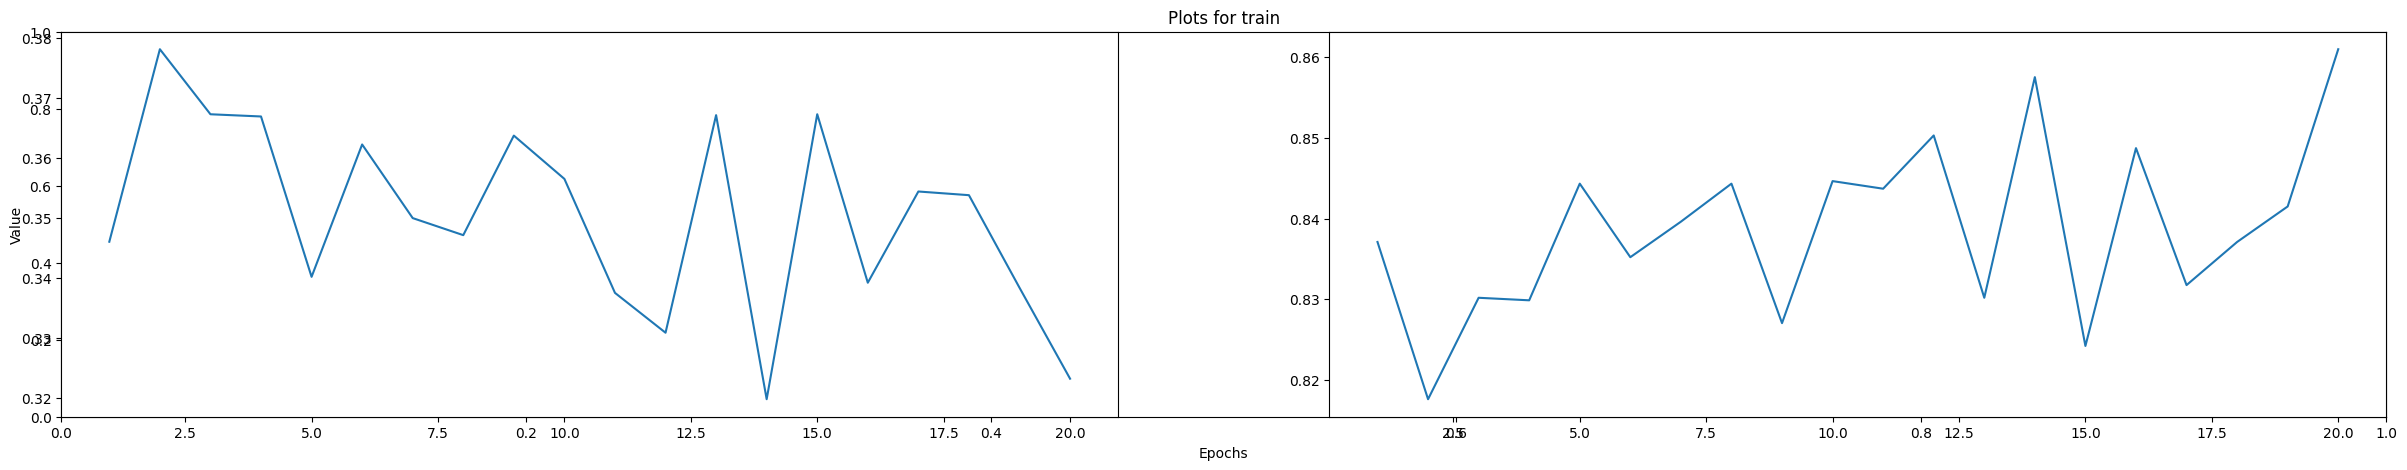

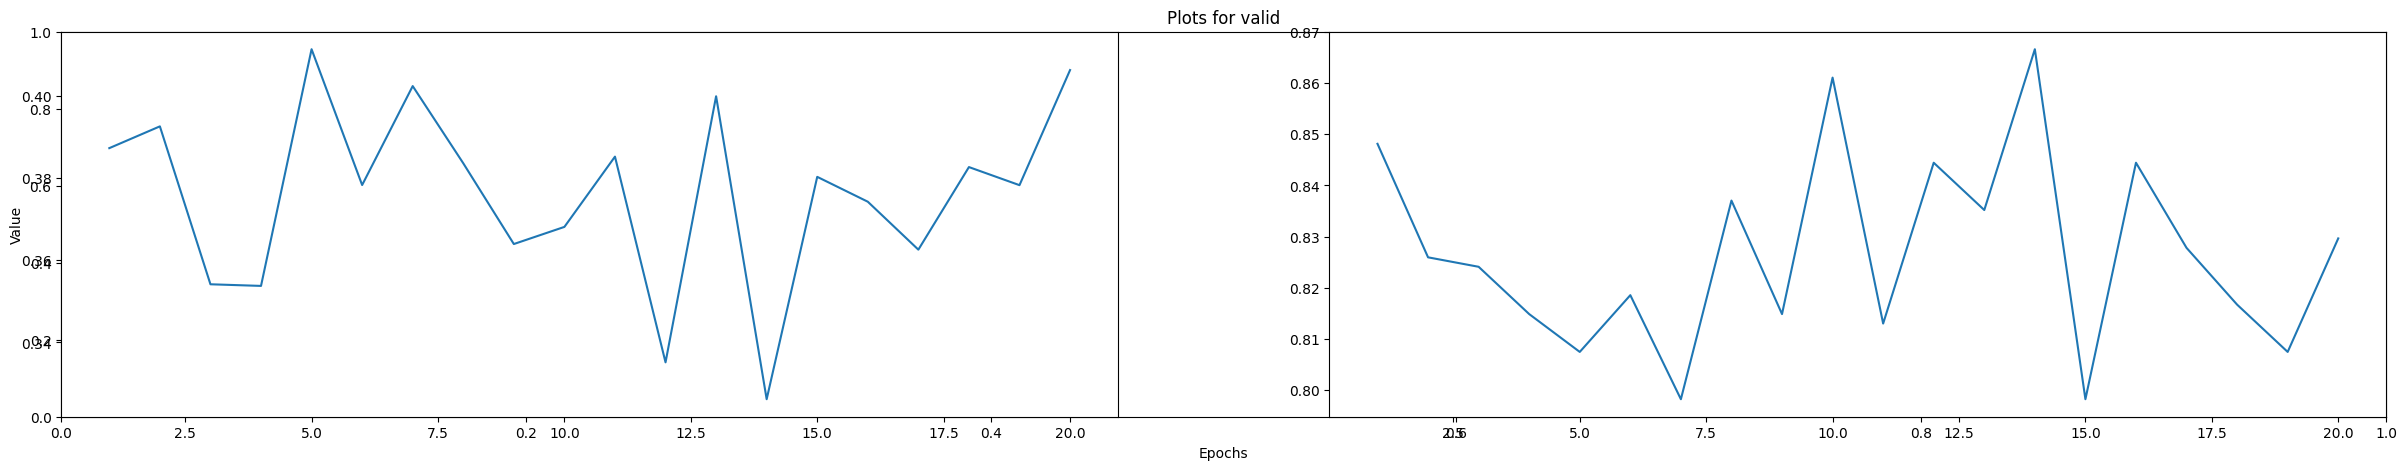

In [20]:
print('Learning rate: 0.0007, Batch size: 10')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=10, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=10, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 20


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8562497496604919, train loss : 0.32751134037971497


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8180555701255798, val_loss : 0.39829427003860474
Epoch : 2, train accuracy : 0.8524999022483826, train loss : 0.3250694274902344
Epoch : 2, val_accuracy : 0.8055554628372192, val_loss : 0.4565412402153015
Epoch : 3, train accuracy : 0.8487499356269836, train loss : 0.3288554549217224
Epoch : 3, val_accuracy : 0.8472222089767456, val_loss : 0.3590886890888214
Epoch : 4, train accuracy : 0.8412501811981201, train loss : 0.3547824025154114
Epoch : 4, val_accuracy : 0.8333333134651184, val_loss : 0.38246503472328186
Epoch : 5, train accuracy : 0.840624988079071, train loss : 0.34881988167762756
Epoch : 5, val_accuracy : 0.8208332657814026, val_loss : 0.3894716203212738
Epoch : 6, train accuracy : 0.8499999046325684, train loss : 0.32232168316841125
Epoch : 6, val_accuracy : 0.7888888716697693, val_loss : 0.40850943326950073
Epoch : 7, train accuracy : 0.8581247925758362, train loss : 0.3199085295200348
Epoch : 7, val_accuracy : 0.7722222208976746, val_loss : 0.4

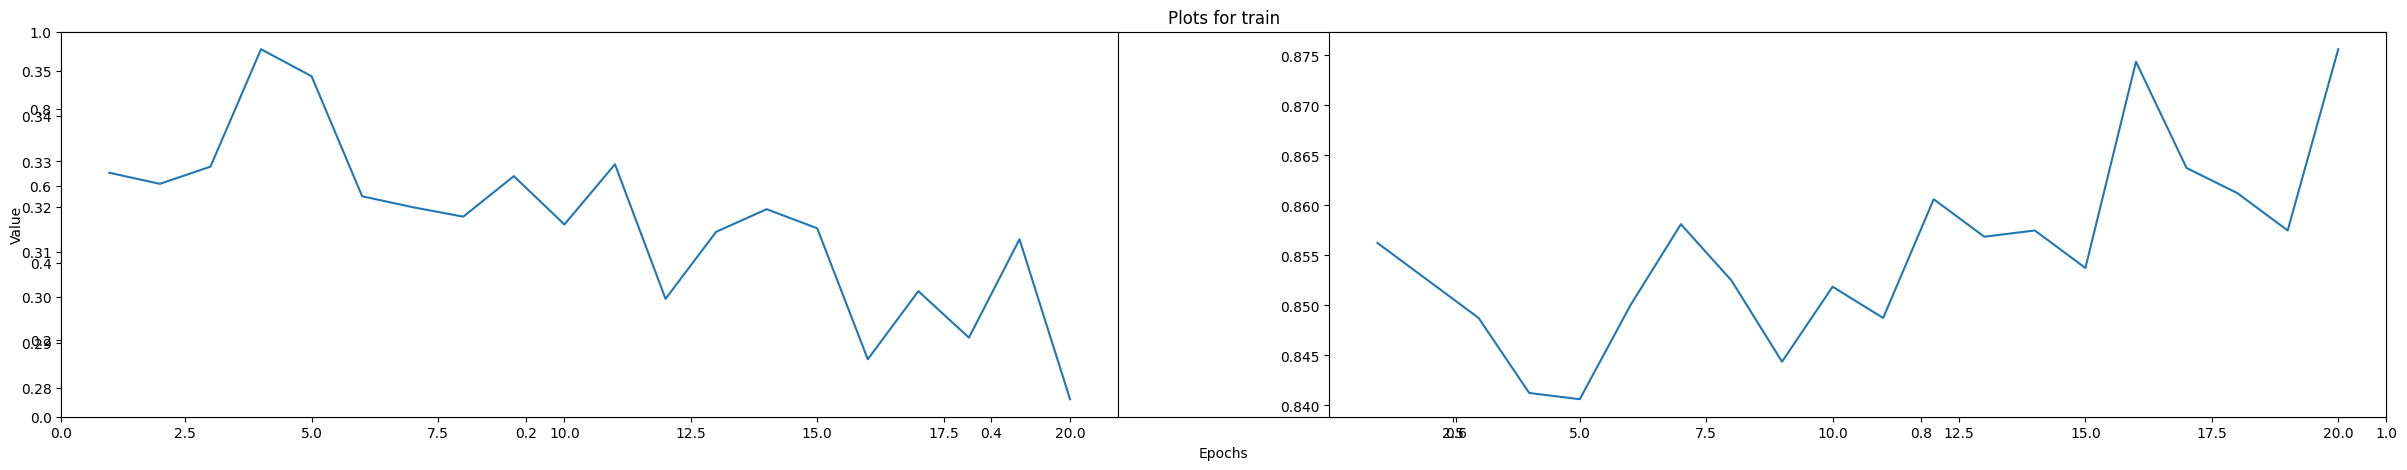

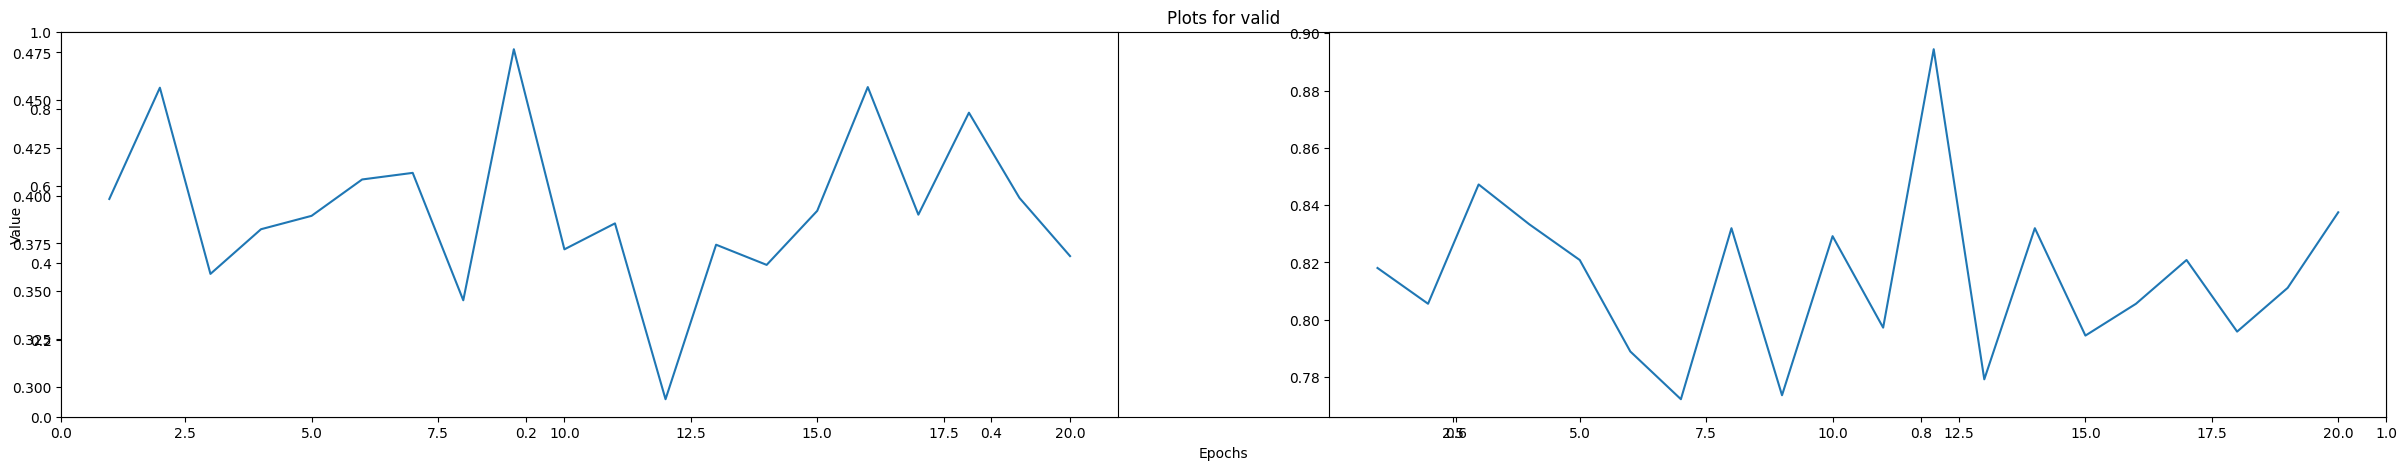

In [21]:
print('Learning rate: 0.001, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 20


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8799998760223389, train loss : 0.26480308175086975


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8722221851348877, val_loss : 0.30644816160202026
Epoch : 2, train accuracy : 0.8781247735023499, train loss : 0.2781936228275299
Epoch : 2, val_accuracy : 0.8194444179534912, val_loss : 0.3479929268360138
Epoch : 3, train accuracy : 0.8756247162818909, train loss : 0.27129635214805603
Epoch : 3, val_accuracy : 0.8138888478279114, val_loss : 0.3813402056694031
Epoch : 4, train accuracy : 0.8712497353553772, train loss : 0.2775301933288574
Epoch : 4, val_accuracy : 0.8680555820465088, val_loss : 0.31345605850219727
Epoch : 5, train accuracy : 0.8812500238418579, train loss : 0.26430079340934753
Epoch : 5, val_accuracy : 0.8361110687255859, val_loss : 0.38108205795288086
Epoch : 6, train accuracy : 0.8668748736381531, train loss : 0.28795549273490906
Epoch : 6, val_accuracy : 0.8041667342185974, val_loss : 0.393719345331192
Epoch : 7, train accuracy : 0.8712499737739563, train loss : 0.29649972915649414
Epoch : 7, val_accuracy : 0.8597221970558167, val_loss : 0

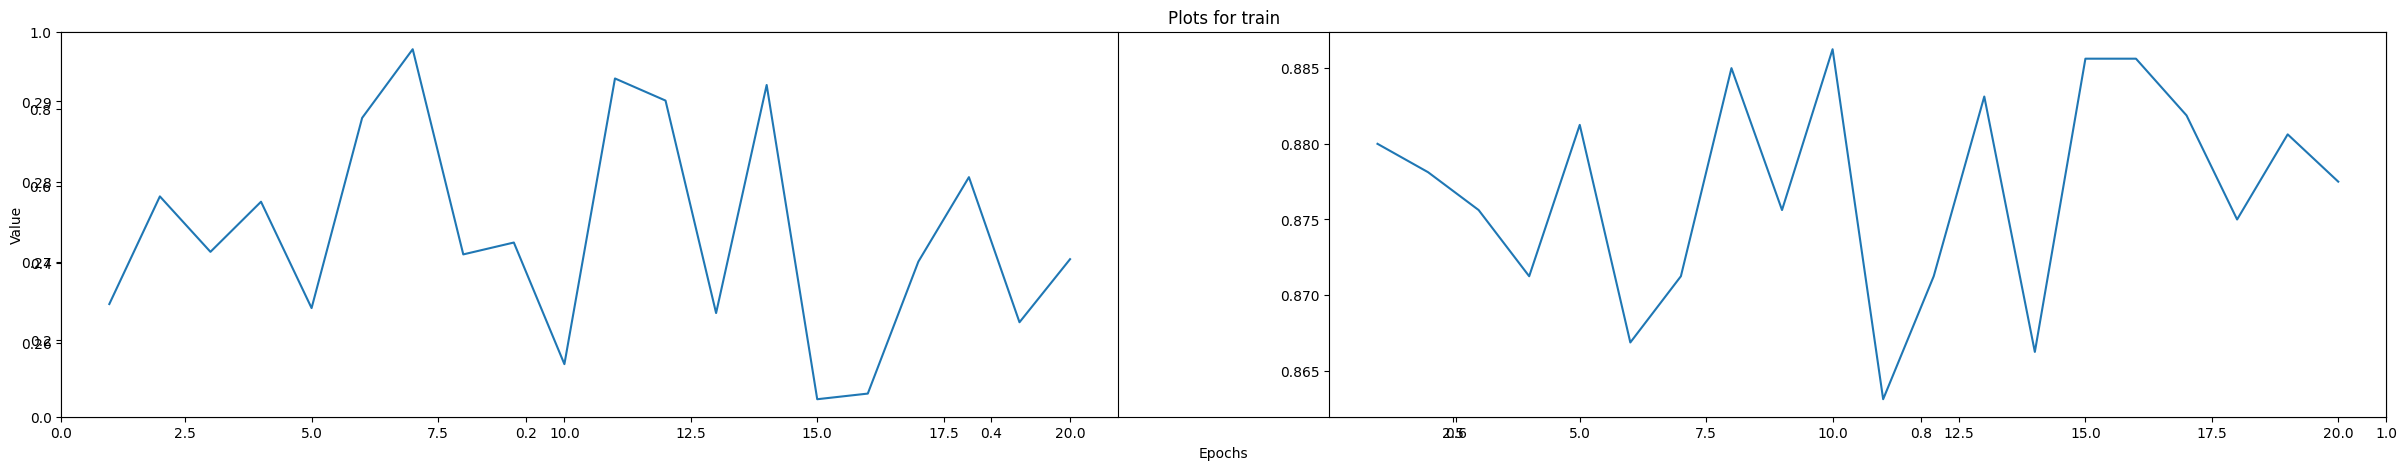

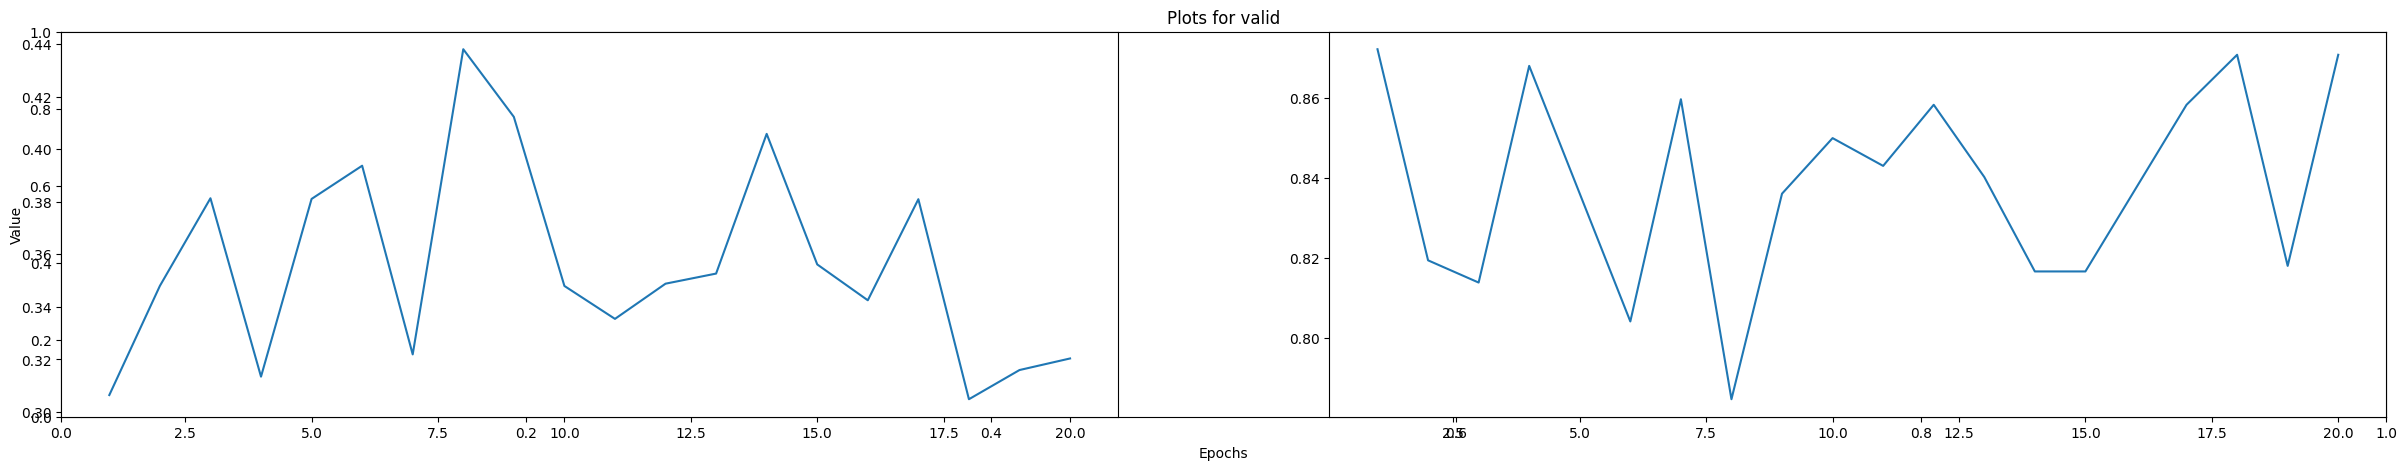

In [22]:
print('Learning rate: 0.0005, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 20


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8787499070167542, train loss : 0.2859609127044678


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8458333015441895, val_loss : 0.3874933421611786
Epoch : 2, train accuracy : 0.8868748545646667, train loss : 0.26806145906448364
Epoch : 2, val_accuracy : 0.8472221493721008, val_loss : 0.3530869483947754
Epoch : 3, train accuracy : 0.8887497782707214, train loss : 0.2645482122898102
Epoch : 3, val_accuracy : 0.8763889074325562, val_loss : 0.3161172568798065
Epoch : 4, train accuracy : 0.8856247663497925, train loss : 0.27201181650161743
Epoch : 4, val_accuracy : 0.8527777791023254, val_loss : 0.3105171322822571
Epoch : 5, train accuracy : 0.8575000762939453, train loss : 0.29040056467056274
Epoch : 5, val_accuracy : 0.8597221970558167, val_loss : 0.35642391443252563
Epoch : 6, train accuracy : 0.8624998331069946, train loss : 0.2808835208415985
Epoch : 6, val_accuracy : 0.8222222924232483, val_loss : 0.3498414158821106
Epoch : 7, train accuracy : 0.866249680519104, train loss : 0.29249629378318787
Epoch : 7, val_accuracy : 0.8569444417953491, val_loss : 0.3

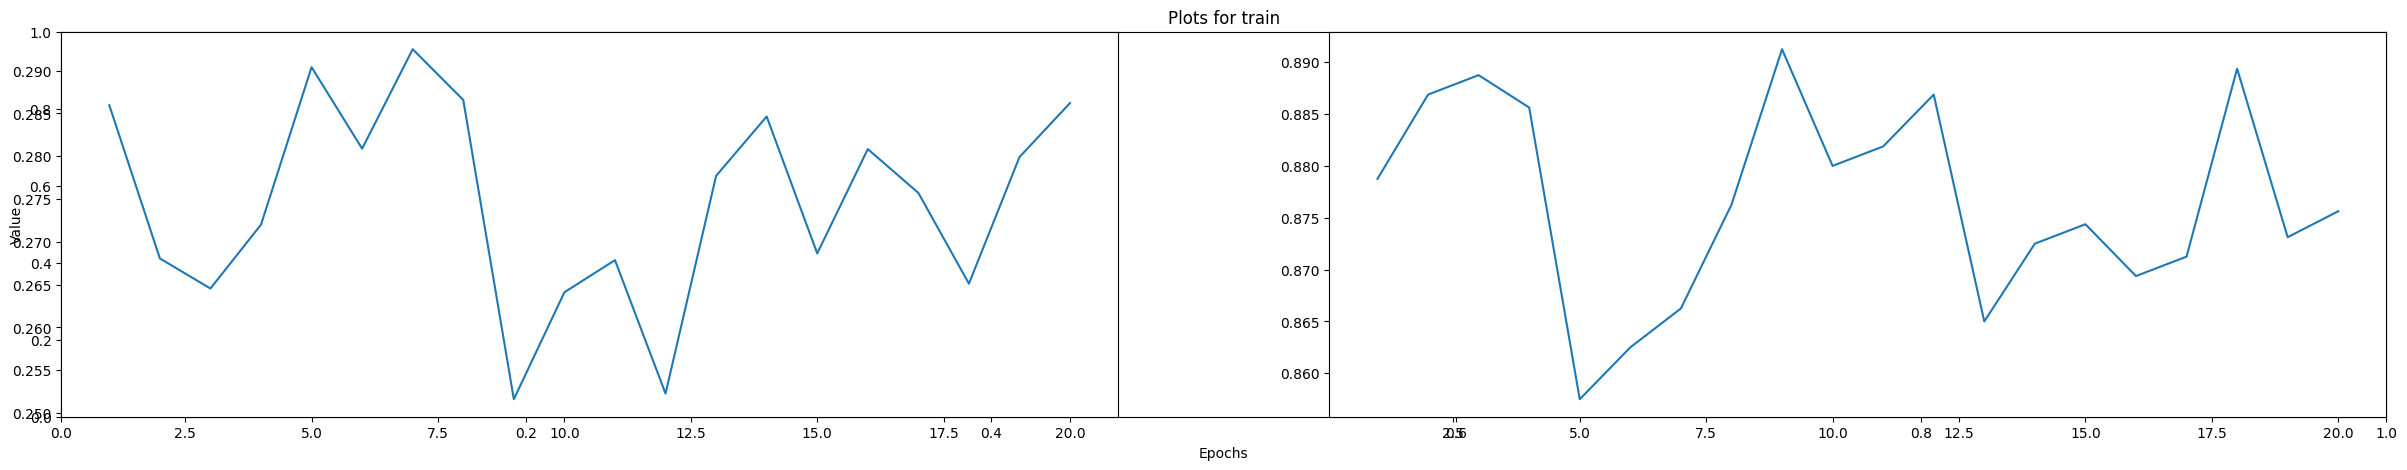

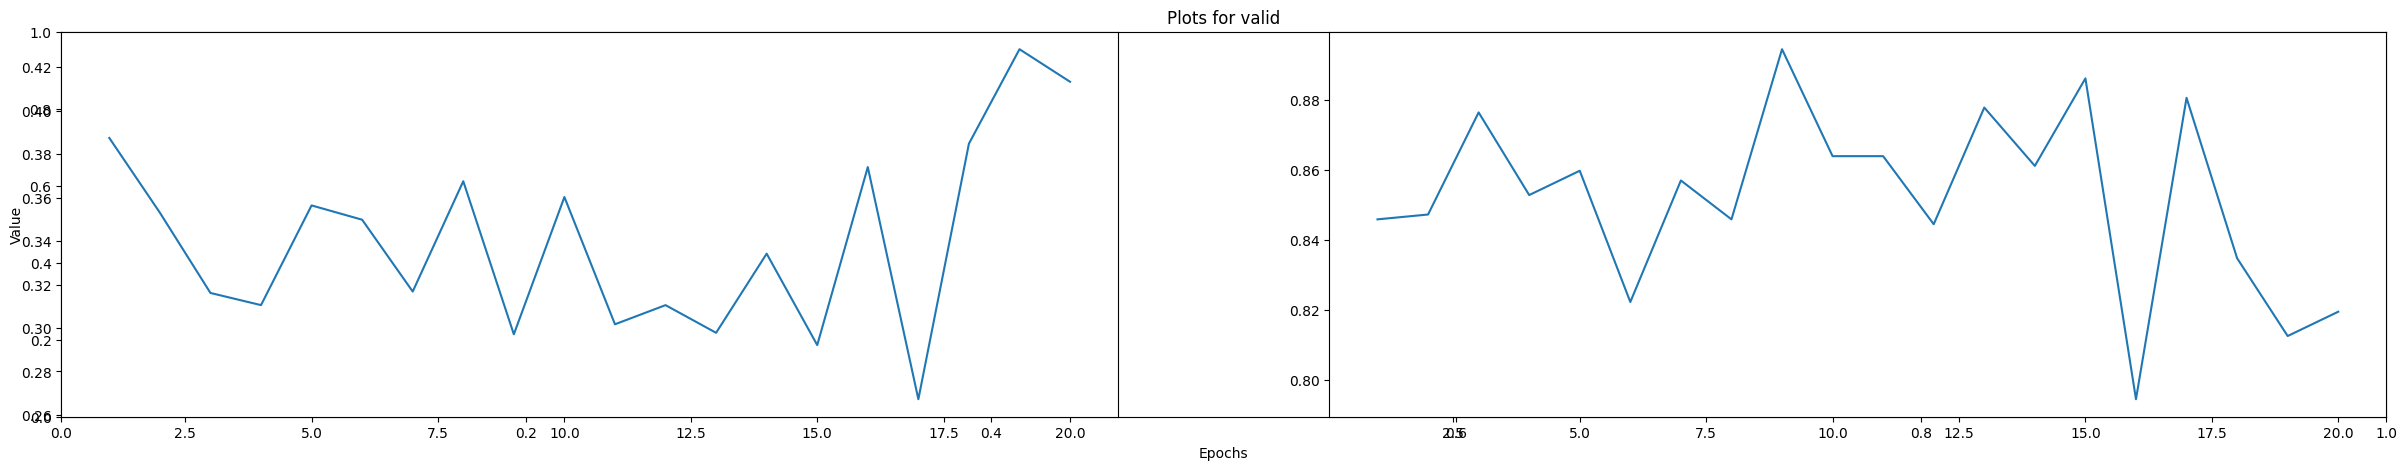

In [23]:
print('Learning rate: 0.0007, Batch size: 20')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=20, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=20, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.001, Batch size: 50


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8872426748275757, train loss : 0.2550586462020874


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8853845596313477, val_loss : 0.28660187125205994
Epoch : 2, train accuracy : 0.8975366950035095, train loss : 0.23821042478084564
Epoch : 2, val_accuracy : 0.7826923131942749, val_loss : 0.42583638429641724
Epoch : 3, train accuracy : 0.8832720518112183, train loss : 0.2599843442440033
Epoch : 3, val_accuracy : 0.895384669303894, val_loss : 0.2850881814956665
Epoch : 4, train accuracy : 0.8981617093086243, train loss : 0.24768108129501343
Epoch : 4, val_accuracy : 0.8615384101867676, val_loss : 0.3838289976119995
Epoch : 5, train accuracy : 0.9025367498397827, train loss : 0.2297319620847702
Epoch : 5, val_accuracy : 0.8461538553237915, val_loss : 0.29970020055770874
Epoch : 6, train accuracy : 0.8834925293922424, train loss : 0.2614973783493042
Epoch : 6, val_accuracy : 0.8569231033325195, val_loss : 0.3442068099975586
Epoch : 7, train accuracy : 0.8941543698310852, train loss : 0.23859377205371857
Epoch : 7, val_accuracy : 0.865384578704834, val_loss : 0.3

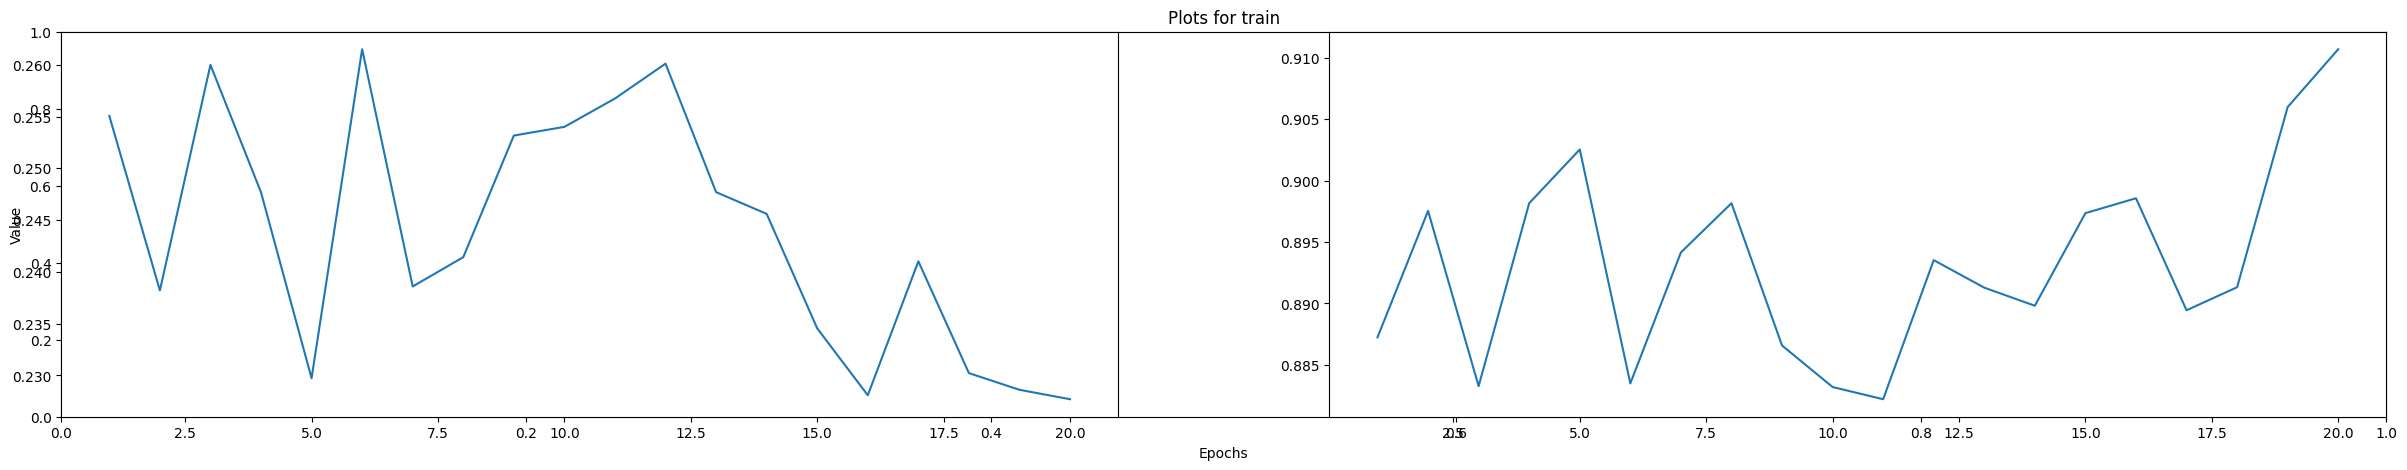

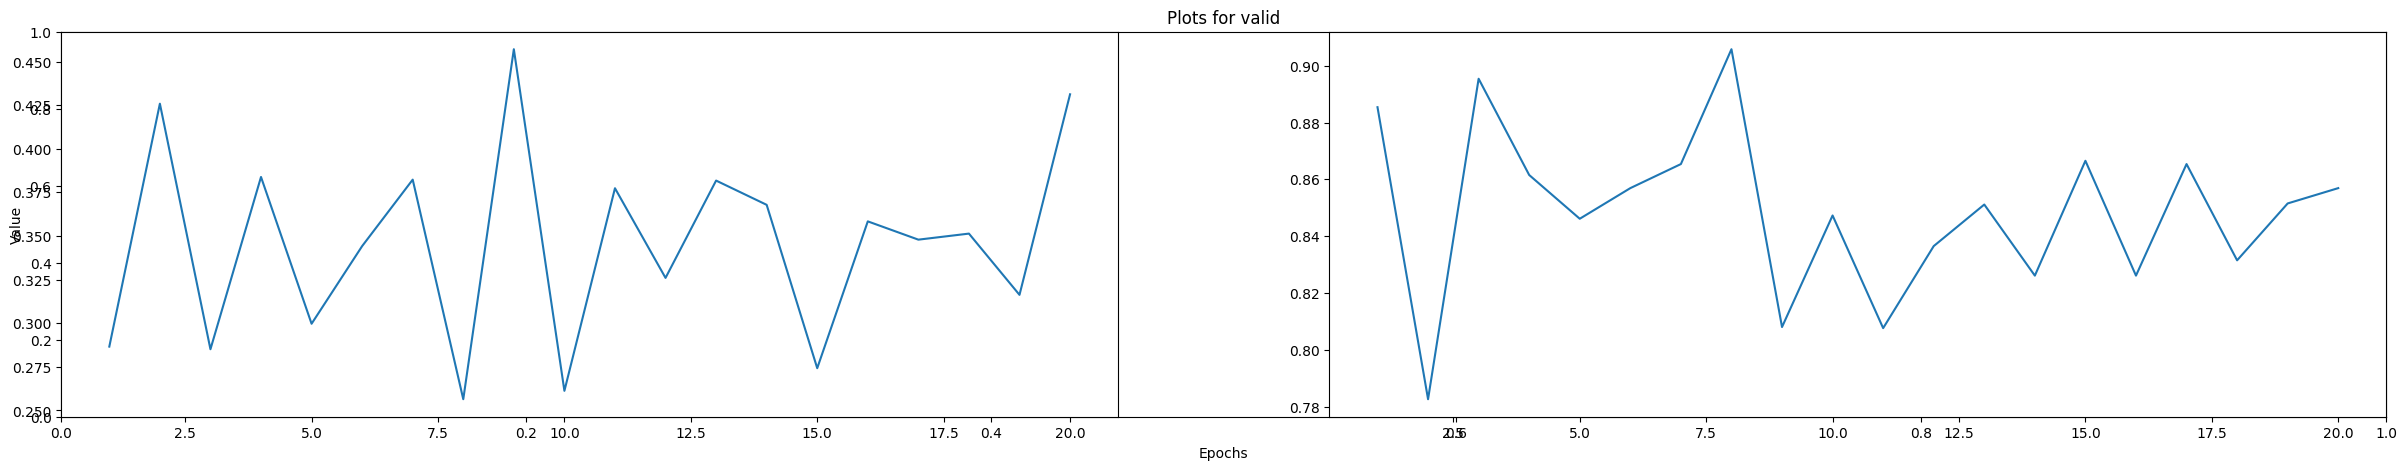

In [24]:
print('Learning rate: 0.001, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0005, Batch size: 50


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.9062867164611816, train loss : 0.21756935119628906


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8611538410186768, val_loss : 0.34028905630111694
Epoch : 2, train accuracy : 0.9110659956932068, train loss : 0.21733498573303223
Epoch : 2, val_accuracy : 0.8373076915740967, val_loss : 0.3302740752696991
Epoch : 3, train accuracy : 0.893823504447937, train loss : 0.2157197892665863
Epoch : 3, val_accuracy : 0.8465384244918823, val_loss : 0.3531690835952759
Epoch : 4, train accuracy : 0.9131616950035095, train loss : 0.2117401659488678
Epoch : 4, val_accuracy : 0.8615384101867676, val_loss : 0.3264968991279602
Epoch : 5, train accuracy : 0.9004043936729431, train loss : 0.2178453654050827
Epoch : 5, val_accuracy : 0.8461538553237915, val_loss : 0.3372512459754944
Epoch : 6, train accuracy : 0.9094485640525818, train loss : 0.21637867391109467
Epoch : 6, val_accuracy : 0.8273077011108398, val_loss : 0.3675195872783661
Epoch : 7, train accuracy : 0.9003307819366455, train loss : 0.2246621698141098
Epoch : 7, val_accuracy : 0.8411538600921631, val_loss : 0.337

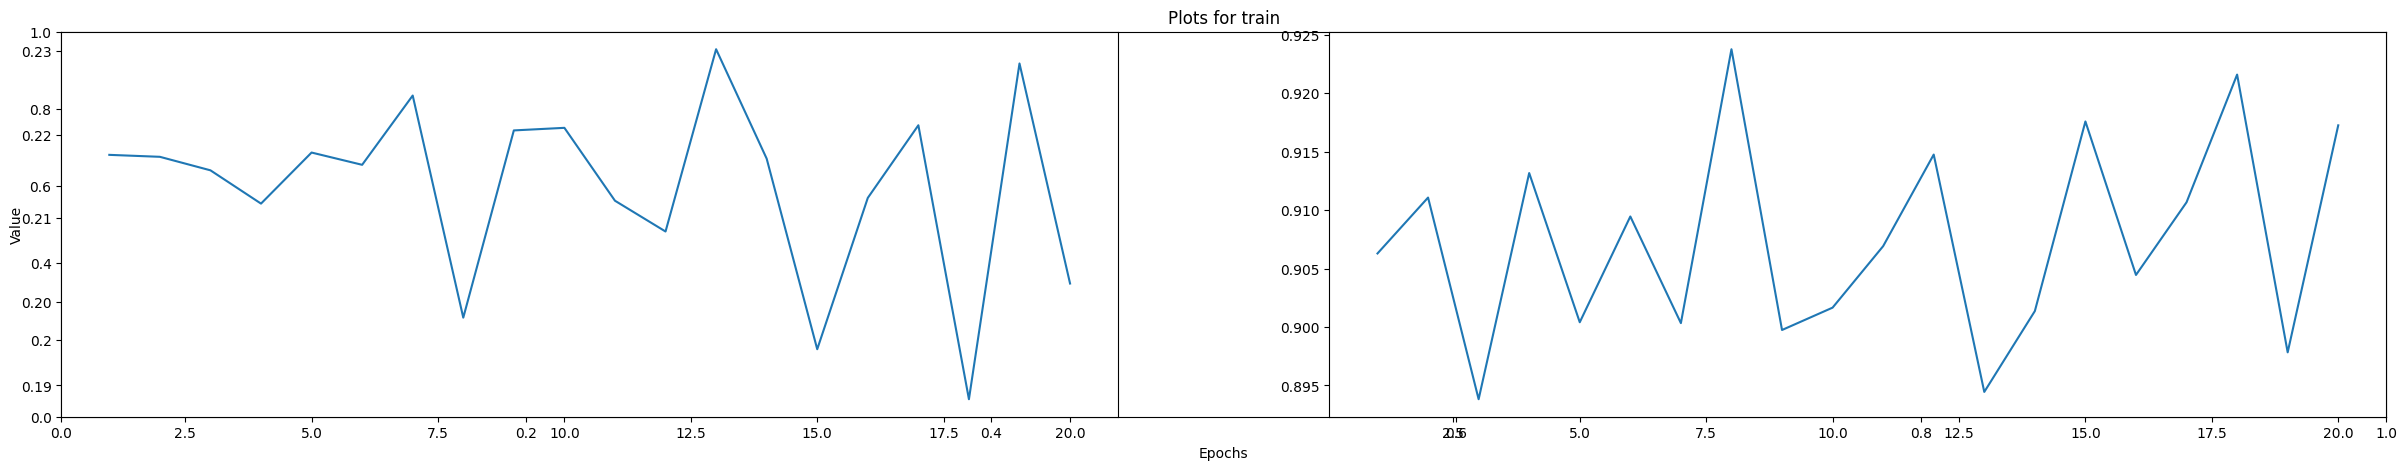

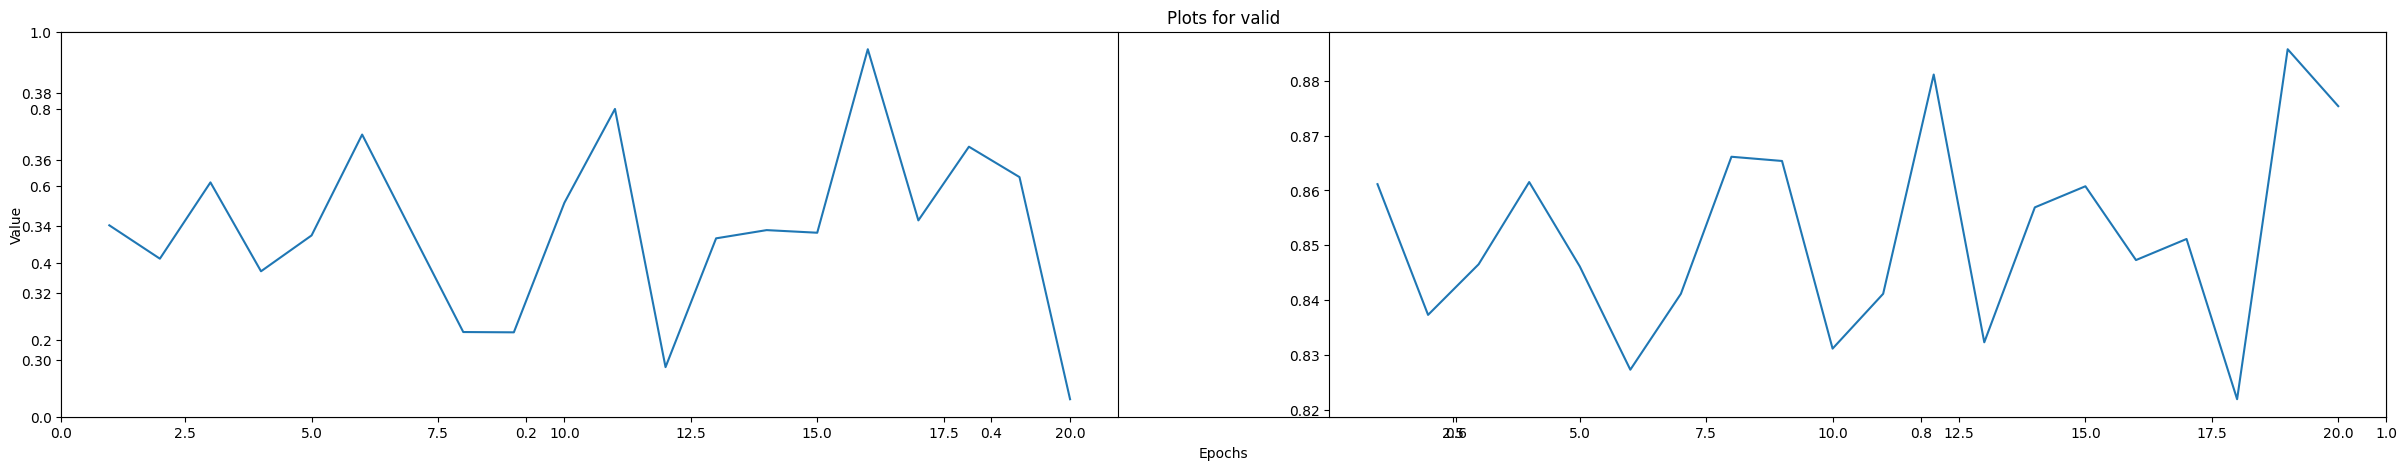

In [25]:
print('Learning rate: 0.0005, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

Learning rate: 0.0007, Batch size: 50


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, train accuracy : 0.8972793221473694, train loss : 0.24267356097698212


C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(device)
C:\Users\sgold\AppData\Local\Temp\ipykernel_3640\1009714177.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


Epoch : 1, val_accuracy : 0.8415384292602539, val_loss : 0.3245190680027008
Epoch : 2, train accuracy : 0.9038968682289124, train loss : 0.21939940750598907
Epoch : 2, val_accuracy : 0.8465384244918823, val_loss : 0.3197779655456543
Epoch : 3, train accuracy : 0.9013234972953796, train loss : 0.22132562100887299
Epoch : 3, val_accuracy : 0.8265384435653687, val_loss : 0.3200232982635498
Epoch : 4, train accuracy : 0.9041174650192261, train loss : 0.22376903891563416
Epoch : 4, val_accuracy : 0.8361538648605347, val_loss : 0.29802075028419495
Epoch : 5, train accuracy : 0.8945587277412415, train loss : 0.2370474934577942
Epoch : 5, val_accuracy : 0.8115384578704834, val_loss : 0.3643771708011627
Epoch : 6, train accuracy : 0.9035293459892273, train loss : 0.22424091398715973
Epoch : 6, val_accuracy : 0.8323076963424683, val_loss : 0.32079991698265076
Epoch : 7, train accuracy : 0.9147058725357056, train loss : 0.21065570414066315
Epoch : 7, val_accuracy : 0.8461538553237915, val_loss : 

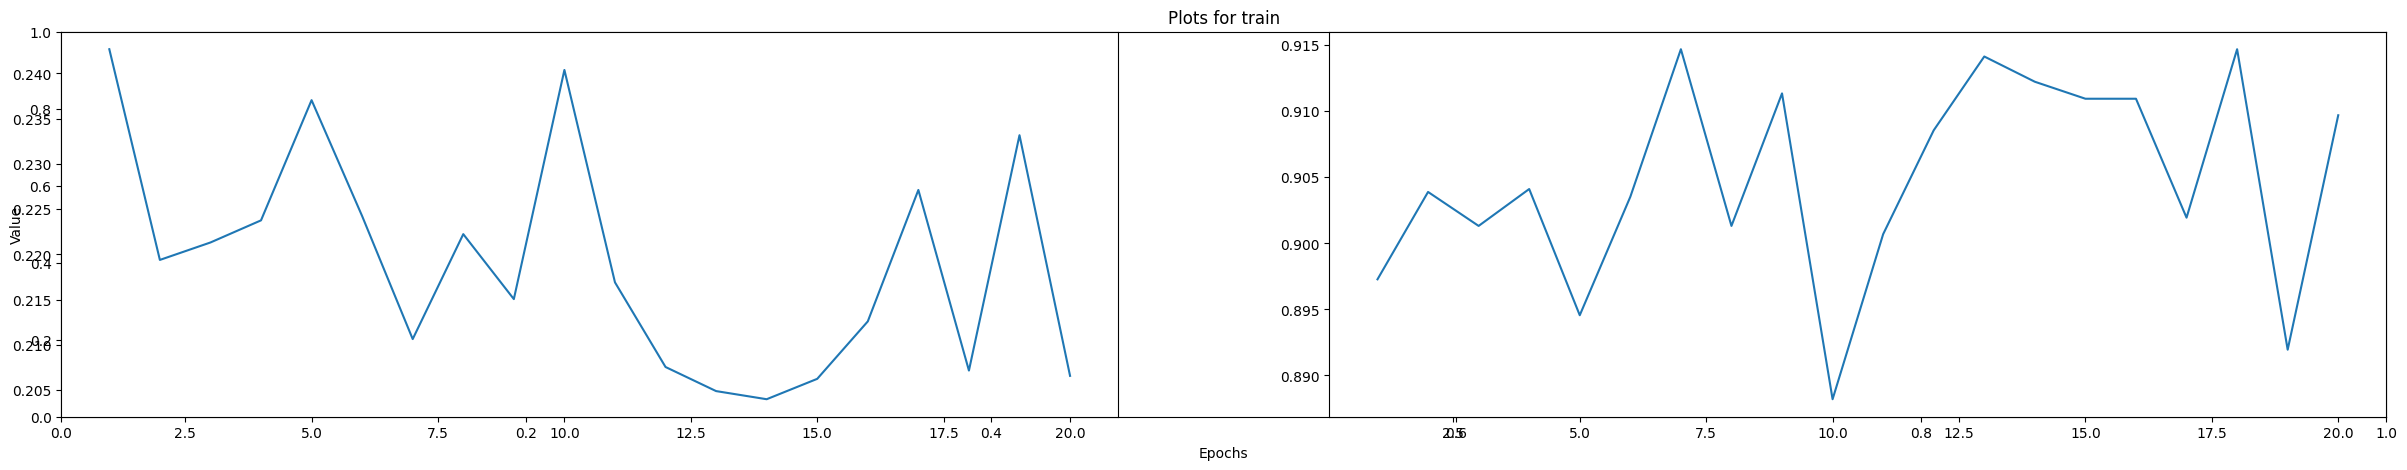

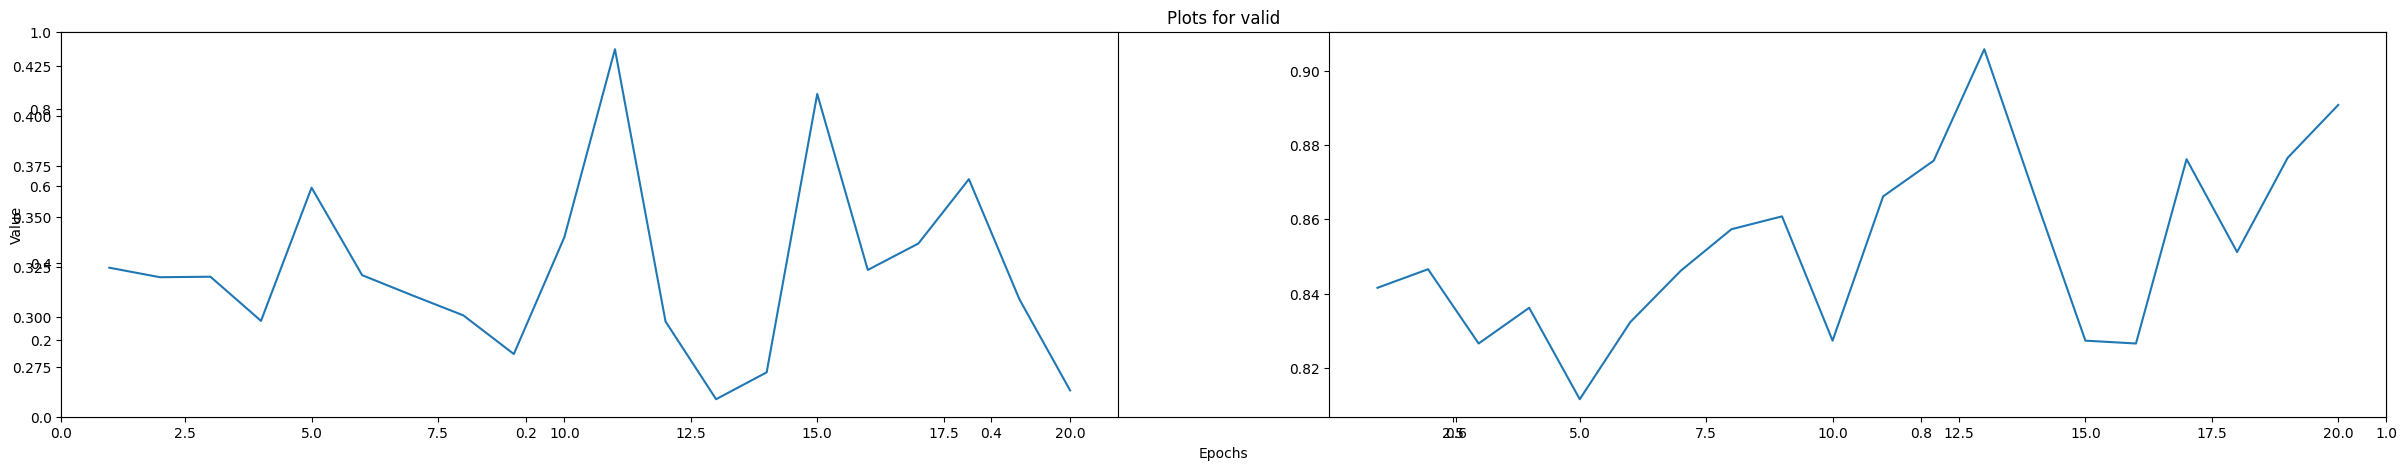

In [26]:
print('Learning rate: 0.0007, Batch size: 50')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=50, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=50, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=50, shuffle=True)

train_loop(train_loader, val_loader, epochs)

In [27]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

,id,label
0,7,0.002094
1,34,0.000551
2,206,0.967987
3,156,0.482090
4,208,0.997695
...,...,...
215,164,0.994432
216,74,0.000092
217,182,0.997281
218,53,0.425595


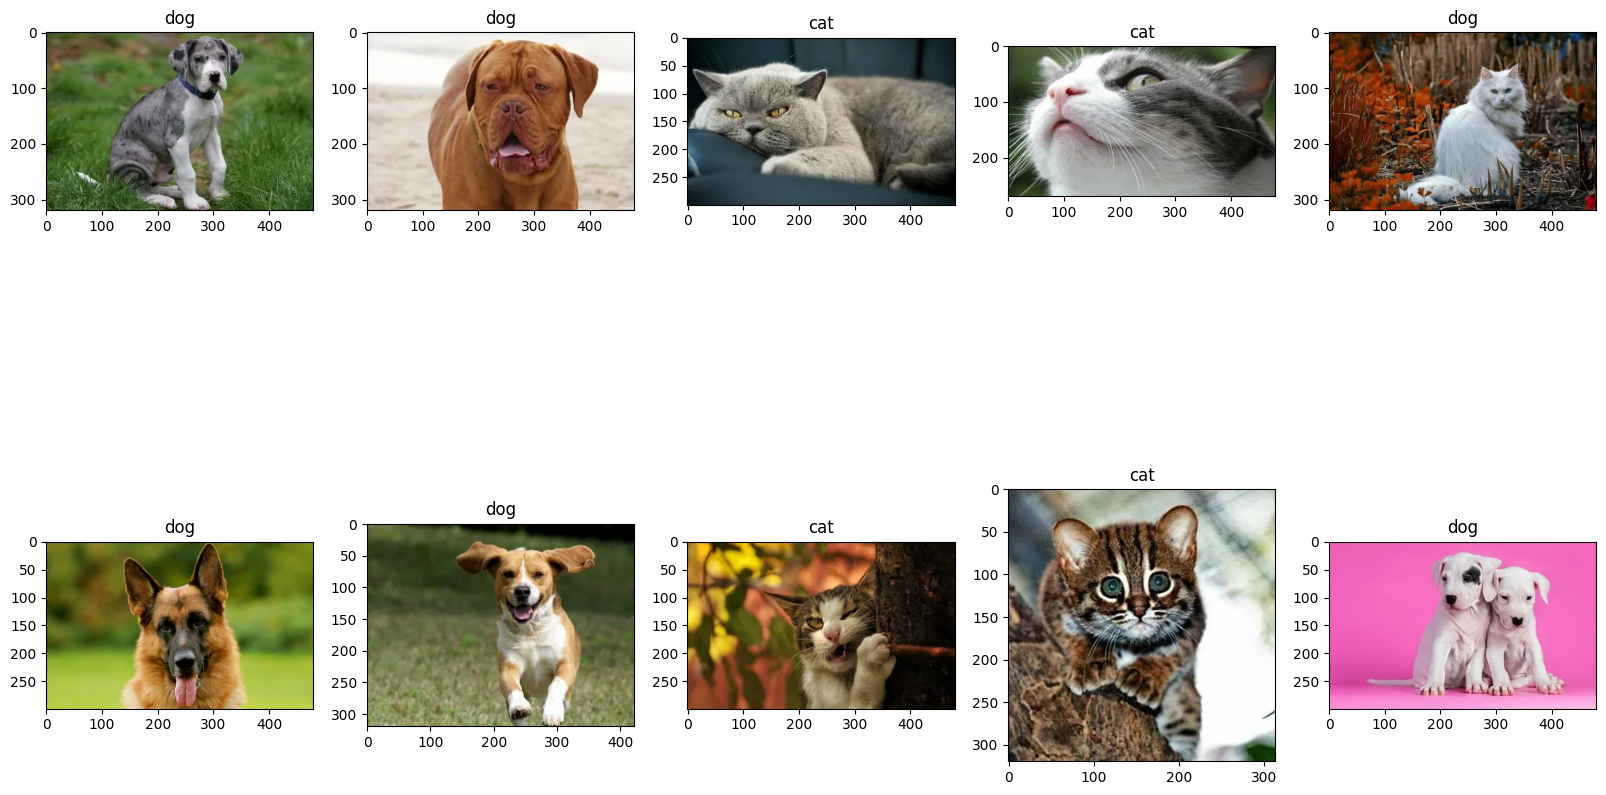

In [28]:
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)